# 임베딩 내 편향성 알아보기

## WEAT 구현하기

In [1]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

두 개의 target 단어 셋 X, Y와 두 개의 attribute 단어 셋 A, B를 정의

단어 셋을 정할 때는 두 개의 target 셋의 크기가 같아야 하고, 두 개의 attribute 셋의 크기가 같아야 함

In [2]:
target_X = {
    '장미': [4.1, 1.2, -2.4, 0.5, 4.1],
    '튤립': [3.1, 0.5, 3.6, 1.7, 5.8],
    '백합': [2.9, -1.3, 0.4, 1.1, 3.7],
    '데이지': [5.4, 2.5, 4.6, -1.0, 3.6]
}
target_Y = {
    '거미': [-1.5, 0.2, -0.6, -4.6, -5.3],
    '모기': [0.4, 0.7, -1.9, -4.5, -2.9],
    '파리': [0.9, 1.4, -2.3, -3.9, -4.7],
    '메뚜기': [0.7, 0.9, -0.4, -4.1, -3.9]
}
attribute_A = {
    '사랑':[2.8,  4.2, 4.3,  0.3, 5.0],
    '행복':[3.8,  3. , -1.2,  4.4, 4.9],
    '웃음':[3.7, -0.3,  1.2, -2.5, 3.9]
}
attribute_B = {
    '재난': [-0.2, -2.8, -4.7, -4.3, -4.7],
    '고통': [-4.5, -2.1,  -3.8, -3.6, -3.1],
    '증오': [-3.6, -3.3, -3.5,  -3.7, -4.4]
}

In [3]:
X = np.array([v for v in target_X.values()])
Y = np.array([v for v in target_Y.values()])
print(X)
print(Y)

[[ 4.1  1.2 -2.4  0.5  4.1]
 [ 3.1  0.5  3.6  1.7  5.8]
 [ 2.9 -1.3  0.4  1.1  3.7]
 [ 5.4  2.5  4.6 -1.   3.6]]
[[-1.5  0.2 -0.6 -4.6 -5.3]
 [ 0.4  0.7 -1.9 -4.5 -2.9]
 [ 0.9  1.4 -2.3 -3.9 -4.7]
 [ 0.7  0.9 -0.4 -4.1 -3.9]]


In [4]:
A = np.array([v for v in attribute_A.values()])
B = np.array([v for v in attribute_B.values()])
print(A)
print(B)

[[ 2.8  4.2  4.3  0.3  5. ]
 [ 3.8  3.  -1.2  4.4  4.9]
 [ 3.7 -0.3  1.2 -2.5  3.9]]
[[-0.2 -2.8 -4.7 -4.3 -4.7]
 [-4.5 -2.1 -3.8 -3.6 -3.1]
 [-3.6 -3.3 -3.5 -3.7 -4.4]]


In [5]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

print(s(target_X['장미'], A, B))

0.6457646122337399


In [6]:
print(s(target_Y['거미'], A, B))

-0.794002342033094


In [7]:
print(s(X, A, B))
print(round(np.mean(s(X, A, B)), 3))

[0.29551989 0.51723181 0.26499096 0.50924109]
0.397


In [8]:
print(s(Y, A, B))
print(round(np.mean(s(Y, A, B)), 3))

[-0.44713039 -0.28310853 -0.33144878 -0.26030641]
-0.33


In [9]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

print(round(weat_score(X, Y, A, B), 3))

1.932


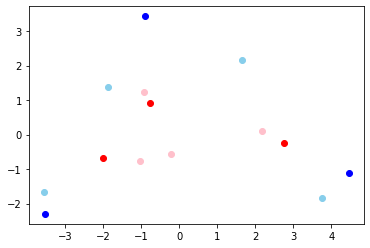

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc_A = pca.fit_transform(A)
pc_B = pca.fit_transform(B)
pc_X = pca.fit_transform(X)
pc_Y = pca.fit_transform(Y)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(pc_A[:,0],pc_A[:,1], c='blue', label='A')
ax.scatter(pc_B[:,0],pc_B[:,1], c='red', label='B')
ax.scatter(pc_X[:,0],pc_X[:,1], c='skyblue', label='X')
ax.scatter(pc_Y[:,0],pc_Y[:,1], c='pink', label='Y')

### 사전학습된 Word Embedding에 WEAT 적용

In [11]:
import os

data_dir = '~/aiffel/weat' 
model_dir = os.path.join(data_dir, 'GoogleNews-vectors-negative300.bin')

from gensim.models import KeyedVectors

# 50만개의 단어만 활용합니다. 메모리가 충분하다면 limit 파라미터값을 생략하여 300만개를 모두 활용할 수 있습니다. 
w2v = KeyedVectors.load_word2vec_format(model_dir, binary=True, limit=500000)

In [12]:
w2v

In [13]:
# print(len(w2v.vocab))   # Gensim 3.X 버전까지는 w2v.vocab을 직접 접근할 수 있습니다. 
print(len(w2v.index_to_key))   # Gensim 4.0부터는 index_to_key를 활용해 vocab size를 알 수 있습니다. 
print(len(w2v['I']))                    # 혹은 단어를 key로 직접 vector를 얻을 수 있습니다. 
print(w2v.vectors.shape)

500000
300
(500000, 300)


In [14]:
w2v['happy']

array([-5.18798828e-04,  1.60156250e-01,  1.60980225e-03,  2.53906250e-02,
        9.91210938e-02, -8.59375000e-02,  3.24218750e-01, -2.17285156e-02,
        1.34765625e-01,  1.10351562e-01, -1.04980469e-01, -2.90527344e-02,
       -2.38037109e-02, -4.02832031e-02, -3.68652344e-02,  2.32421875e-01,
        3.20312500e-01,  1.01074219e-01,  5.83496094e-02, -2.91824341e-04,
       -3.29589844e-02,  2.11914062e-01,  4.32128906e-02, -8.59375000e-02,
        2.81250000e-01, -1.78222656e-02,  3.79943848e-03, -1.71875000e-01,
        2.06054688e-01, -1.85546875e-01,  3.73535156e-02, -1.21459961e-02,
        2.04101562e-01, -3.80859375e-02,  3.61328125e-02, -8.15429688e-02,
        8.44726562e-02,  9.37500000e-02,  1.44531250e-01,  7.42187500e-02,
        2.51953125e-01, -7.91015625e-02,  8.69140625e-02,  1.58691406e-02,
        1.09375000e-01, -2.23632812e-01, -5.15747070e-03,  1.68945312e-01,
       -1.36718750e-01, -2.51464844e-02, -3.85742188e-02, -1.33056641e-02,
        1.38671875e-01,  

In [15]:
# 'happy'와 가장 유사한 단어
w2v.most_similar(positive=['happy'])

[('glad', 0.7408890724182129),
 ('pleased', 0.6632170677185059),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049172401428),
 ('satisfied', 0.6437949538230896),
 ('proud', 0.636042058467865),
 ('delighted', 0.627237856388092),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247665286064148)]

In [16]:
# 다른 단어들도 확인
w2v.most_similar(positive=['family'])

[('relatives', 0.6662653088569641),
 ('familiy', 0.6517067551612854),
 ('families', 0.6252894997596741),
 ('siblings', 0.6140849590301514),
 ('friends', 0.6128394603729248),
 ('mother', 0.6065612435340881),
 ('aunt', 0.5811319947242737),
 ('grandparents', 0.5762072205543518),
 ('father', 0.5717043876647949),
 ('Family', 0.5672314763069153)]

In [17]:
w2v.most_similar(positive=['school'])

[('elementary', 0.7868632078170776),
 ('schools', 0.7411909103393555),
 ('elementary_schools', 0.6597153544425964),
 ('kindergarten', 0.6529811024665833),
 ('eighth_grade', 0.6488089561462402),
 ('School', 0.6477997303009033),
 ('teacher', 0.63824063539505),
 ('students', 0.6301522850990295),
 ('classroom', 0.6281620264053345),
 ('Schools', 0.6172096133232117)]

### WEAT를 통해 이 모델의 편향성을 확인

In [18]:
target_X = ['science', 'technology', 'physics', 'chemistry', 'Einstein', 'NASA', 'experiment', 'astronomy']
target_Y = ['poetry', 'art', 'Shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']
attribute_A = ['brother', 'father', 'uncle', 'grandfather', 'son', 'he', 'his', 'him']
attribute_B = ['sister', 'mother', 'aunt', 'grandmother', 'daughter', 'she', 'hers', 'her']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.2624874

In [19]:
target_X = ['science', 'technology', 'physics', 'chemistry', 'Einstein', 'NASA', 'experiment', 'astronomy']
target_Y = ['poetry', 'art', 'Shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']
attribute_A = ['brother', 'father', 'uncle', 'grandfather', 'son', 'he', 'his', 'him']
attribute_B = ['sister', 'mother', 'aunt', 'grandmother', 'daughter', 'she', 'hers', 'her']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.2624874

In [20]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['junk', 'canned', 'convenience', 'frozen', 'fast']
attribute_B = ['health', 'beneficial', 'good', 'nourishing', 'nutritious']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.6909266

In [21]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['book', 'essay', 'dictionary', 'magazine', 'novel']
attribute_B = ['news', 'report', 'statement', 'broadcast', 'word']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

-0.05137869

In [22]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['brother', 'father', 'uncle', 'grandfather', 'son', 'he', 'his', 'him']
attribute_B = ['sister', 'mother', 'aunt', 'grandmother', 'daughter', 'she', 'hers', 'her']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

0.33343452

In [23]:
#메모리를 다시 비워줍시다.
del w2v
print("삭제 완료")

삭제 완료


## 직접 만드는 Word Embedding에 WEAT 적용(1)
- 형태소 분석기를 이용하여 품사가 명사인 경우, 해당 단어를 추출하기
- 추출된 결과로 embedding model 만들기
- TF/IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기
- embedding model과 단어 셋으로 WEAT score 구해보기

### 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [24]:
import os

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

In [25]:
# 약 15분정도 걸립니다.
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

print("슝~")

슝~


In [26]:
print(len(tokenized))

71156


### 추출된 결과로 embedding model 만들기


In [27]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
# model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
# model.most_similar(positive=['영화'])

[('작품', 0.896767795085907),
 ('다큐멘터리', 0.8506894707679749),
 ('드라마', 0.8237006664276123),
 ('영화로', 0.8113967776298523),
 ('코미디', 0.7929070591926575),
 ('형식', 0.7916682958602905),
 ('스토리', 0.7841081619262695),
 ('실화', 0.7781686782836914),
 ('주제', 0.7767983078956604),
 ('코믹', 0.7755871415138245)]

In [28]:
model.wv.most_similar(positive=['사랑'])

[('애정', 0.707463264465332),
 ('만남', 0.6857402324676514),
 ('진심', 0.6820480227470398),
 ('첫사랑', 0.679892361164093),
 ('연애', 0.6756413578987122),
 ('행복', 0.6713691353797913),
 ('운명', 0.6690787076950073),
 ('이별', 0.6660068035125732),
 ('우정', 0.664566159248352),
 ('가슴', 0.6633977890014648)]

In [29]:
model.wv.most_similar(positive=['연극'])

[('시나리오', 0.8944110870361328),
 ('배우', 0.884371817111969),
 ('연기', 0.8790336847305298),
 ('캐스팅', 0.8751378655433655),
 ('대본', 0.864495038986206),
 ('팬', 0.8639851212501526),
 ('영화감독', 0.8622598052024841),
 ('공연', 0.8622381091117859),
 ('데뷔', 0.8560974597930908),
 ('영감', 0.8559992909431458)]

## 직접 만드는 Word Embedding에 WEAT 적용(2)

### TF-IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기
두 축을 영화 장르, 영화 구분 정보를 이용

(영화 구분 정보란 일반영화, 예술영화, 독립영화로 구분된 정보입니다. KOBIS에서 제공한 정보를 기준으로 분류)

 명사에 대해서만 추출하여 art, gen 변수에 할당

In [31]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

print("슝~")

슝~


In [32]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


단어 셋 구성을 위해 TF-IDF방식을 사용

In [33]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [34]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [35]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

상위 100개의 단어들 중 중복되는 단어를 제외하고 상위 n(=15)개의 단어를 추출

In [36]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [37]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [38]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


전체 장르 고려

In [39]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [40]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [41]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [42]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

### embedding model과 단어 셋으로 WEAT score 구해보기

In [43]:
def cos_sim(i, j): #cos_sim 코사인 유사도
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)  # 단어 w에 대해 A 데이터셋의 단어들과 코사인유사도를 구한다.
    c_b = cos_sim(w, B)  # 단어 w에 대해 B 데이터셋의 단어들과 코사인유사도를 구한다.
    mean_A = np.mean(c_a, axis=-1)    #axis 축  attribute_A
    mean_B = np.mean(c_b, axis=-1)    #axis 축  attribute_B
    return mean_A - mean_B#, c_a, c_b

def weat_score(X, Y, A, B): #target X,Y,  attribute_A,B
    
    s_X = s(X, A, B)  #target X, attribute_A,B
    s_Y = s(Y, A, B)  #target Y, attribute_A,B

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0)) #concatenate 지정된 축에서 여러 배열을 연결
    
    return  (mean_X-mean_Y)/std_dev # (mean_X-mean_Y)/ std_dev 표준편차

In [44]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [45]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [46]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.5295581
SF 공연 -0.37009597
SF 공포(호러) -0.65199167
SF 기타 0.36282143
SF 다큐멘터리 0.5889394
SF 드라마 -0.38804963
SF 멜로로맨스 -0.76989776
SF 뮤지컬 0.34363732
SF 미스터리 -0.6664746
SF 범죄 -0.23311356
SF 사극 -0.84398276
SF 서부극(웨스턴) -0.43703517
SF 성인물(에로) -0.5495886
SF 스릴러 -0.51961625
SF 애니메이션 0.3768718
SF 액션 -0.4505088
SF 어드벤처 -0.8140384
SF 전쟁 0.22101066
SF 코미디 -0.44410035
SF 판타지 -0.2045189
가족 공연 0.20555133
가족 공포(호러) -0.14152937
가족 기타 0.75925386
가족 다큐멘터리 0.82661146
가족 드라마 0.21921307
가족 멜로로맨스 -0.5824246
가족 뮤지컬 0.7007369
가족 미스터리 -0.29768524
가족 범죄 0.21219921
가족 사극 -0.075360246
가족 서부극(웨스턴) 0.41611737
가족 성인물(에로) -0.27752504
가족 스릴러 -0.13705613
가족 애니메이션 0.87020224
가족 액션 0.11212115
가족 어드벤처 -0.039102066
가족 전쟁 0.6510069
가족 코미디 0.21274957
가족 판타지 0.41738132
공연 공포(호러) -0.2391301
공연 기타 0.94310015
공연 다큐멘터리 0.91335076
공연 드라마 -0.020859335
공연 멜로로맨스 -0.67529804
공연 뮤지컬 0.8805916
공연 미스터리 -0.35038188
공연 범죄 0.066606775
공연 사극 -0.37665182
공연 서부극(웨스턴) 0.023233104
공연 성인물(에로) -0.45113075
공연 스릴러 -0.2233209
공연 애니메이션 0.9126664
공연

<AxesSubplot:>

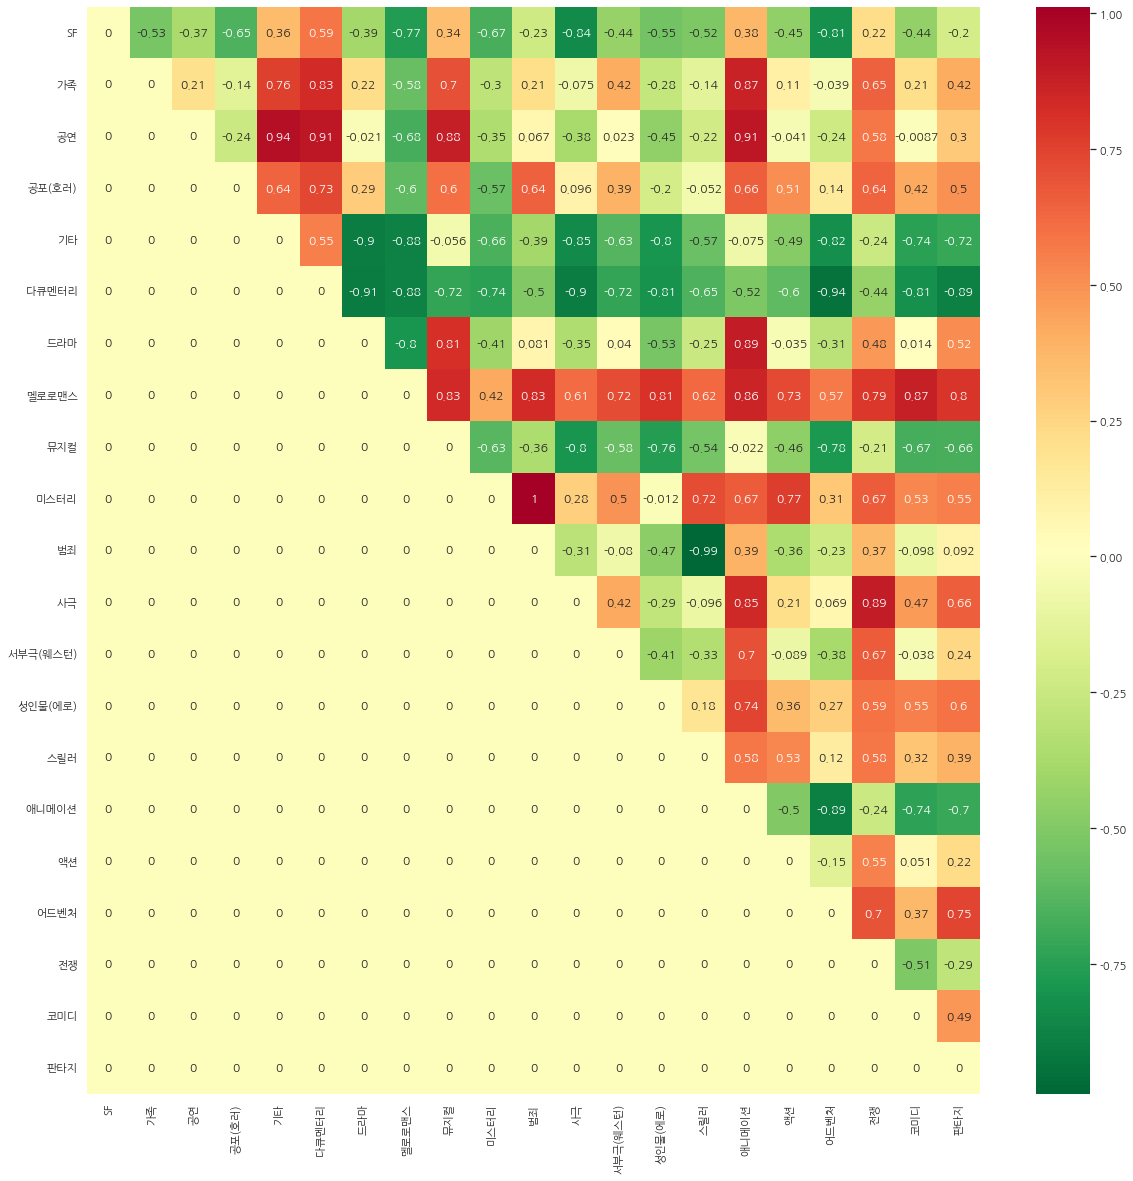

In [48]:
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,20))
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

## 회고

공부를 해도 해도 끝이 없다..지금 밑바닥인줄은 알았는데 더 밑바닥이다

### WEAT(Word Embedding Association Test)
워드 임베딩 벡터들 간에는 의미적인 유사도 거리를 정량적으로 측정할 수 있다.
### Word Embedding Association Test (WEAT)
임베딩 모델의 편향을 측정하는 방식 중 하나로, 워드 임베딩에 내포된 편향성도 정량적으로 측정할 방법
#### WEAT
WEAT는 Male과 Female, Science와 Art라는 개념을 가장 잘 대표하는 단어들을 여러 개 골라 단어 셋(set)을 만든다.

이러한 단어 셋을 WEAT에서는 각각 target과 attribute이라고 부름
### WEAT를 통한 편향성 측정
- WEAT score
1. 두 벡터의 유사도를 측정하기 위해 cosine similarity를 이용
2. cosine similarity는 두 벡터 사이의 cosine 값을 이용하여 두 벡터의 유사도를 측정
다시 말해, 두 벡터 i, ji,j가 주어졌을 때, cosine similarity cos(\theta)cos(θ)는 dot product와 magnitude를 사용하여 구할 수 있다.
- cos(θ)=1: 두 벡터의 방향이 똑같을 때
- cos(θ)=0: 두 벡터가 직교할 때
- cos(θ)=−1: 두 벡터의 방향이 반대일 때
편향성 값은 -2에서 2사이의 값을 가지게 되며, 그 절댓값이 클수록 ww는 A-B 개념축에 대해 편향성을 가진다는 뜻